## Uso de modelos de clasificación para la detección de fraude de tarjetas bancarias

- El siguiente trabajo es una revisión de modelos de clasificación de fraude en compras de tarjeta de crédito.
- La base original se puede descargar de kaggle con la dirección: path = kagglehub.dataset_download("ealaxi/banksim1")

import kagglehub

# Download latest version
path = kagglehub.dataset_download("ealaxi/banksim1")

print("Path to dataset files:", path)

### 1. Análisis Exploratorio (EDA):
- Importar librerias
- Carga y limpieza de datos
- Estadísticos básicos
- Balance de clases
- Ajustes varios - resultado de análisis de balance de clases
- Distribución y outliers

#### Importar librerias

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.patheffects as path_effects
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from catboost import CatBoostClassifier, metrics
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, auc, average_precision_score
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches

#### Carga y limpieza de datos

- Cargamos el archivo csv y lo transformamos a un dataframe

In [2]:
df = pd.read_csv(r"bs140513_032310.csv")
df

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0
...,...,...,...,...,...,...,...,...,...,...
594638,179,'C1753498738','3','F','28007','M1823072687','28007','es_transportation',20.53,0
594639,179,'C650108285','4','F','28007','M1823072687','28007','es_transportation',50.73,0
594640,179,'C123623130','2','F','28007','M349281107','28007','es_fashion',22.44,0
594641,179,'C1499363341','5','M','28007','M1823072687','28007','es_transportation',14.46,0


- Revisamos el tipo de datos de cada columna

In [3]:
df.dtypes

step             int64
customer        object
age             object
gender          object
zipcodeOri      object
merchant        object
zipMerchant     object
category        object
amount         float64
fraud            int64
dtype: object

- Eliminamos las comillas para todos los datos de tipo objeto

In [4]:
for col in df.select_dtypes(include='object'):
    df[col] = df[col].str.replace("'", "")
df

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,C1093826151,4,M,28007,M348934600,28007,es_transportation,4.55,0
1,0,C352968107,2,M,28007,M348934600,28007,es_transportation,39.68,0
2,0,C2054744914,4,F,28007,M1823072687,28007,es_transportation,26.89,0
3,0,C1760612790,3,M,28007,M348934600,28007,es_transportation,17.25,0
4,0,C757503768,5,M,28007,M348934600,28007,es_transportation,35.72,0
...,...,...,...,...,...,...,...,...,...,...
594638,179,C1753498738,3,F,28007,M1823072687,28007,es_transportation,20.53,0
594639,179,C650108285,4,F,28007,M1823072687,28007,es_transportation,50.73,0
594640,179,C123623130,2,F,28007,M349281107,28007,es_fashion,22.44,0
594641,179,C1499363341,5,M,28007,M1823072687,28007,es_transportation,14.46,0


- Todos los datos pertenecen al mismo codigo postal - eliminamos esas columnas

In [5]:
df = df.drop(['zipcodeOri','zipMerchant' ], axis=1)
df

,step,customer,age,gender,merchant,category,amount,fraud
0,0,C1093826151,4,M,M348934600,es_transportation,4.55,0
1,0,C352968107,2,M,M348934600,es_transportation,39.68,0
2,0,C2054744914,4,F,M1823072687,es_transportation,26.89,0
3,0,C1760612790,3,M,M348934600,es_transportation,17.25,0
4,0,C757503768,5,M,M348934600,es_transportation,35.72,0
...,...,...,...,...,...,...,...,...
594638,179,C1753498738,3,F,M1823072687,es_transportation,20.53,0
594639,179,C650108285,4,F,M1823072687,es_transportation,50.73,0
594640,179,C123623130,2,F,M349281107,es_fashion,22.44,0
594641,179,C1499363341,5,M,M1823072687,es_transportation,14.46,0


- Convertir columnas (step y fraud) a tipo categórico

In [6]:
df['step'] = df['step'].astype('category')
df['fraud'] = df['fraud'].astype('category')
df.dtypes


step        category
customer      object
age           object
gender        object
merchant      object
category      object
amount       float64
fraud       category
dtype: object

#### Estadísticos básicos

- Reviso si hay valores nulos

In [7]:
df.isnull().sum()

step        0
customer    0
age         0
gender      0
merchant    0
category    0
amount      0
fraud       0
dtype: int64

- Dimensión del dataset

In [8]:
print(f"Registros: {df.shape[0]}, Columnas: {df.shape[1]}\n")

Registros: 594643, Columnas: 8



- Tipos de datos y valores nulos

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   step      594643 non-null  category
 1   customer  594643 non-null  object  
 2   age       594643 non-null  object  
 3   gender    594643 non-null  object  
 4   merchant  594643 non-null  object  
 5   category  594643 non-null  object  
 6   amount    594643 non-null  float64 
 7   fraud     594643 non-null  category
dtypes: category(2), float64(1), object(5)
memory usage: 28.9+ MB


- Análisis de variables numéricas

In [10]:
df.describe()

,amount
count,594643.000000
mean,37.890135
std,111.402831
min,0.000000
25%,13.740000
50%,26.900000
75%,42.540000
max,8329.960000


- Análisis de variables categóricas

In [11]:
categorical_cols = ['customer','merchant','category', 'gender', 'age', 'step','fraud']

for col in categorical_cols:
    print("\n" + "-"*30)
    print(f"Variable: {col}")
    print(df[col].value_counts(normalize=True).head(10))  # Top 10 categorías


------------------------------
Variable: customer
customer
C1978250683    0.000446
C1275518867    0.000424
C806399525     0.000399
C515668508     0.000345
C1338396147    0.000328
C1896850232    0.000323
C1350963410    0.000321
C980876590     0.000318
C582688427     0.000316
C359363895     0.000316
Name: proportion, dtype: float64

------------------------------
Variable: merchant
merchant
M1823072687    0.503988
M348934600     0.345461
M85975013      0.044151
M1053599405    0.011471
M151143676     0.010717
M855959430     0.010255
M1946091778    0.008985
M1913465890    0.006707
M209847108     0.006414
M480139044     0.005899
Name: proportion, dtype: float64

------------------------------
Variable: category
category
es_transportation        0.849449
es_food                  0.044151
es_health                0.027131
es_wellnessandbeauty     0.025370
es_fashion               0.010854
es_barsandrestaurants    0.010717
es_hyper                 0.010255
es_sportsandtoys         0.006730
es

- Análisis de valores únicos

In [12]:
unique_counts = df[categorical_cols].nunique().sort_values(ascending=False)
unique_counts

customer    4112
step         180
merchant      50
category      15
age            8
gender         4
fraud          2
dtype: int64

#### Balance de clases

##### Estadísticos de montos por tipo de transacción

In [13]:
df.groupby('fraud')['amount'].describe().T

C:\Users\ferna\AppData\Local\Temp\ipykernel_2932\2341598960.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('fraud')['amount'].describe().T


fraud,0,1
count,587443.000000,7200.000000
mean,31.847230,530.926551
std,31.470876,835.587112
min,0.000000,0.030000
25%,13.590000,159.980000
50%,26.610000,319.175000
75%,41.895000,548.977500
max,2144.860000,8329.960000


#####  Agregamos columna de rango edades para visualizaciones (no para los modelos)

In [14]:
age_range = {
'0' : '<=18',
'1' : '19-25',
'2' : '26-35',
'3' : '36-45',
'4' : '46-55',
'5' : '56-65',
'6' : '>65',
'U' : 'Unknown'
}

if 'range' not in df.columns:
    df.insert(loc=3, column='range', value=df['age'].map(age_range))
df

,step,customer,age,range,gender,merchant,category,amount,fraud
0,0,C1093826151,4,46-55,M,M348934600,es_transportation,4.55,0
1,0,C352968107,2,26-35,M,M348934600,es_transportation,39.68,0
2,0,C2054744914,4,46-55,F,M1823072687,es_transportation,26.89,0
3,0,C1760612790,3,36-45,M,M348934600,es_transportation,17.25,0
4,0,C757503768,5,56-65,M,M348934600,es_transportation,35.72,0
...,...,...,...,...,...,...,...,...,...
594638,179,C1753498738,3,36-45,F,M1823072687,es_transportation,20.53,0
594639,179,C650108285,4,46-55,F,M1823072687,es_transportation,50.73,0
594640,179,C123623130,2,26-35,F,M349281107,es_fashion,22.44,0
594641,179,C1499363341,5,56-65,M,M1823072687,es_transportation,14.46,0


##### Análisis de conteo de transacciones

In [15]:
print("\n" + "="*50)
print("Conteo de TRANSACCIONES por categoría (ordenado por fraude):")
category_fraud = pd.crosstab(df['category'], df['fraud'])
category_fraud = category_fraud.sort_values(by=1, ascending=False)
print(category_fraud)

print("\n\n" + "="*50)
print("Conteo de TRANSACCIONES por rango de edad (ordenado por fraude):")
orden_range = ['<=18','19-25','26-35','36-45','46-55','56-65','>65','Unknown']
df['range'] = pd.Categorical(df['range'], categories=orden_range, ordered=True)
age_fraud = pd.crosstab(df['range'], df['fraud'])
age_fraud = age_fraud.sort_values(by=1, ascending=False)
print(age_fraud)

print("\n\n" + "="*50)
print("Conteo de TRANSACCIONES por Comerciante (Top 20, ordenado por fraude):")
merchant_fraud = pd.crosstab(df['merchant'], df['fraud'])
top_fraud_merchants = merchant_fraud.sort_values(by=1, ascending=False).head(20)
print(top_fraud_merchants)

print("\n\n" + "="*50)
print("Conteo de TRANSACCIONES por Género (ordenado por fraude):")
gender_fraud = pd.crosstab(df['gender'], df['fraud'])
gender_fraud = gender_fraud.sort_values(by=1, ascending=False)
print(gender_fraud)


Conteo de TRANSACCIONES por categoría (ordenado por fraude):
fraud                       0     1
category                           
es_sportsandtoys         2020  1982
es_health               14437  1696
es_wellnessandbeauty    14368   718
es_travel                 150   578
es_hotelservices         1196   548
es_leisure                 25   474
es_home                  1684   302
es_hyper                 5818   280
es_otherservices          684   228
es_tech                  2212   158
es_barsandrestaurants    6253   120
es_fashion               6338   116
es_contents               885     0
es_food                 26254     0
es_transportation      505119     0


Conteo de TRANSACCIONES por rango de edad (ordenado por fraude):
fraud         0     1
range                
26-35    184966  2344
36-45    145376  1755
46-55    107615  1410
19-25     57442   689
56-65     61956   686
>65       26513   261
<=18       2404    48
Unknown    1171     7


Conteo de TRANSACCIONES por Comercian

##### Análisis de porcentaje de transacciones (normalize='index')
    - Dentro de esta categoría, qué porcentaje de transacciones son fraudulentas

- Función para formatear porcentajes

In [16]:
def format_percent(val):
    return f"{val:.2%}"

In [17]:
print("\n" + "="*50)
print("Distribución de TRANSACCIONES por categoría (ordenado por % fraude):")
category_fraud = pd.crosstab(df['category'], df['fraud'], normalize='index')
category_fraud = category_fraud.sort_values(by=1, ascending=False)
print(category_fraud.map(format_percent))

print("\n\n" + "="*50)
print("Distribución de TRANSACCIONES por rango de edad (ordenado por % fraude):")
orden_range = ['<=18','19-25','26-35','36-45','46-55','56-65','>65','Unknown']
df['range'] = pd.Categorical(df['range'], categories=orden_range, ordered=True)
age_fraud = pd.crosstab(df['range'], df['fraud'], normalize='index')
age_fraud = age_fraud.sort_values(by=1, ascending=False)
print(age_fraud.map(format_percent))

print("\n\n" + "="*50)
print("Distribución de TRANSACCIONES por Comerciante (Top 20, ordenado por % fraude):")
merchant_fraud = pd.crosstab(df['merchant'], df['fraud'], normalize='index')
top_fraud_merchants = merchant_fraud.sort_values(by=1, ascending=False).head(20)
print(top_fraud_merchants.map(format_percent))

print("\n\n" + "="*50)
print("Distribución de TRANSACCIONES por Género (ordenado por % fraude):")
gender_fraud = pd.crosstab(df['gender'], df['fraud'], normalize='index')
gender_fraud = gender_fraud.sort_values(by=1, ascending=False)
print(gender_fraud.map(format_percent))


Distribución de TRANSACCIONES por categoría (ordenado por % fraude):
fraud                        0       1
category                              
es_leisure               5.01%  94.99%
es_travel               20.60%  79.40%
es_sportsandtoys        50.47%  49.53%
es_hotelservices        68.58%  31.42%
es_otherservices        75.00%  25.00%
es_home                 84.79%  15.21%
es_health               89.49%  10.51%
es_tech                 93.33%   6.67%
es_wellnessandbeauty    95.24%   4.76%
es_hyper                95.41%   4.59%
es_barsandrestaurants   98.12%   1.88%
es_fashion              98.20%   1.80%
es_contents            100.00%   0.00%
es_food                100.00%   0.00%
es_transportation      100.00%   0.00%


Distribución de TRANSACCIONES por rango de edad (ordenado por % fraude):
fraud         0      1
range                 
<=18     98.04%  1.96%
46-55    98.71%  1.29%
26-35    98.75%  1.25%
36-45    98.81%  1.19%
19-25    98.81%  1.19%
56-65    98.90%  1.10%
>65     

##### Análisis de porcentaje de transacciones (normalize='columns')
    - De todos los fraudes, qué porcentaje ocurre en esta categoría

In [18]:
print("\n" + "="*50)
print("Distribución de TRANSACCIONES por categoría (ordenado por % del total de fraudes):")
category_fraud = pd.crosstab(df['category'], df['fraud'], normalize='columns')
category_fraud = category_fraud.sort_values(by=1, ascending=False)
print(category_fraud.map(format_percent))

print("\n\n" + "="*50)
print("Distribución de TRANSACCIONES por rango de edad (ordenado por % del total de fraudes):")
orden_range = ['<=18','19-25','26-35','36-45','46-55','56-65','>65','Unknown']
df['range'] = pd.Categorical(df['range'], categories=orden_range, ordered=True)
age_fraud = pd.crosstab(df['range'], df['fraud'], normalize='columns')
age_fraud = age_fraud.sort_values(by=1, ascending=False)
print(age_fraud.map(format_percent))

print("\n\n" + "="*50)
print("Distribución de TRANSACCIONES por Comerciante (Top 20, ordenado por % del total de fraudes):")
merchant_fraud = pd.crosstab(df['merchant'], df['fraud'], normalize='columns')
top_fraud_merchants = merchant_fraud.sort_values(by=1, ascending=False).head(20)
print(top_fraud_merchants.map(format_percent))

print("\n\n" + "="*50)
print("Distribución de TRANSACCIONES por Género (ordenado por % del total de fraudes):")
gender_fraud = pd.crosstab(df['gender'], df['fraud'], normalize='columns')
gender_fraud = gender_fraud.sort_values(by=1, ascending=False)
print(gender_fraud.map(format_percent))


Distribución de TRANSACCIONES por categoría (ordenado por % del total de fraudes):
fraud                       0       1
category                             
es_sportsandtoys        0.34%  27.53%
es_health               2.46%  23.56%
es_wellnessandbeauty    2.45%   9.97%
es_travel               0.03%   8.03%
es_hotelservices        0.20%   7.61%
es_leisure              0.00%   6.58%
es_home                 0.29%   4.19%
es_hyper                0.99%   3.89%
es_otherservices        0.12%   3.17%
es_tech                 0.38%   2.19%
es_barsandrestaurants   1.06%   1.67%
es_fashion              1.08%   1.61%
es_contents             0.15%   0.00%
es_food                 4.47%   0.00%
es_transportation      85.99%   0.00%


Distribución de TRANSACCIONES por rango de edad (ordenado por % del total de fraudes):
fraud         0       1
range                  
26-35    31.49%  32.56%
36-45    24.75%  24.38%
46-55    18.32%  19.58%
19-25     9.78%   9.57%
56-65    10.55%   9.53%
>65       4.5

##### Análisis de porcentaje de montos (normalización por filas)
    - Dentro de esta categoría, qué porcentaje del monto es fraudulento vs legítimo

- Función para calcular porcentajes de montos por filas

In [19]:
def calculate_amount_percentage_by_row(group_col):
    total_amount = df.groupby([group_col, 'fraud'])['amount'].sum().unstack(fill_value=0)
    return total_amount.div(total_amount.sum(axis=1), axis=0)

In [20]:
print("\n\n" + "="*50)
print("Distribución de MONTOS por categoría (ordenado por % fraude):")
category_amount = calculate_amount_percentage_by_row('category')
category_amount = category_amount.sort_values(by=1, ascending=False)
print(category_amount.map(format_percent))

print("\n\n" + "="*50)
print("Distribución de MONTOS por rango de edad (ordenado por % fraude):")
age_amount = calculate_amount_percentage_by_row('range')
age_amount = age_amount.sort_values(by=1, ascending=False)
print(age_amount.map(format_percent))

print("\n\n" + "="*50)
print("Distribución de MONTOS por Comerciante (Top 20, ordenado por % fraude):")
merchant_amount = calculate_amount_percentage_by_row('merchant')
top_merchant_amount = merchant_amount.sort_values(by=1, ascending=False).head(20)
print(top_merchant_amount.map(format_percent))

print("\n\n" + "="*50)
print("Distribución de MONTOS por Género (ordenado por % fraude):")
gender_amount = calculate_amount_percentage_by_row('gender')
gender_amount = gender_amount.sort_values(by=1, ascending=False)
print(gender_amount.map(format_percent))



Distribución de MONTOS por categoría (ordenado por % fraude):
fraud                        0       1
category                              
es_leisure               1.27%  98.73%
es_travel                6.13%  93.87%
es_sportsandtoys        20.71%  79.29%
es_hotelservices        35.54%  64.46%
es_otherservices        41.77%  58.23%
es_home                 58.01%  41.99%
es_health               68.45%  31.55%
es_tech                 77.11%  22.89%
es_hyper                83.09%  16.91%
es_wellnessandbeauty    83.33%  16.67%
es_barsandrestaurants   92.89%   7.11%
es_fashion              93.24%   6.76%
es_contents            100.00%   0.00%
es_food                100.00%   0.00%
es_transportation      100.00%   0.00%


Distribución de MONTOS por rango de edad (ordenado por % fraude):
fraud         0       1
range                  
<=18     72.39%  27.61%
26-35    81.98%  18.02%
46-55    82.31%  17.69%
36-45    83.23%  16.77%
19-25    84.22%  15.78%
56-65    85.29%  14.71%
>65      85.5

C:\Users\ferna\AppData\Local\Temp\ipykernel_2932\478526918.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_amount = df.groupby([group_col, 'fraud'])['amount'].sum().unstack(fill_value=0)
C:\Users\ferna\AppData\Local\Temp\ipykernel_2932\478526918.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_amount = df.groupby([group_col, 'fraud'])['amount'].sum().unstack(fill_value=0)
C:\Users\ferna\AppData\Local\Temp\ipykernel_2932\478526918.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current b

##### Análisis de porcentaje de montos (normalización por columnas)
    - De todo el dinero perdido en fraudes, qué porcentaje proviene de esta categoría

- Función para calcular porcentajes de montos por columnas

In [21]:
def calculate_amount_percentage_by_column(df, group_col):
    total_amount = df.groupby([group_col, 'fraud'])['amount'].sum().unstack(fill_value=0)
    return total_amount.div(total_amount.sum(axis=0), axis=1)

In [22]:
print("\n\n" + "="*50)
print("Distribución de MONTOS por categoría (ordenado por % fraude):")
category_amount = calculate_amount_percentage_by_column(df,'category')
category_amount = category_amount.sort_values(by=1, ascending=False)
print(category_amount.map(format_percent))

print("\n\n" + "="*50)
print("Distribución de MONTOS por rango de edad (ordenado por % fraude):")
age_amount = calculate_amount_percentage_by_column(df,'range')
age_amount = age_amount.sort_values(by=1, ascending=False)
print(age_amount.map(format_percent))

print("\n\n" + "="*50)
print("Distribución de MONTOS por Comerciante (Top 20, ordenado por % fraude):")
merchant_amount = calculate_amount_percentage_by_column(df,'merchant')
top_merchant_amount = merchant_amount.sort_values(by=1, ascending=False).head(20)
print(top_merchant_amount.map(format_percent))

print("\n\n" + "="*50)
print("Distribución de MONTOS por Género (ordenado por % fraude):")
gender_amount = calculate_amount_percentage_by_column(df,'gender')
gender_amount = gender_amount.sort_values(by=1, ascending=False)
print(gender_amount.map(format_percent))



Distribución de MONTOS por categoría (ordenado por % fraude):


C:\Users\ferna\AppData\Local\Temp\ipykernel_2932\619754514.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_amount = df.groupby([group_col, 'fraud'])['amount'].sum().unstack(fill_value=0)


fraud                       0       1
category                             
es_travel               0.54%  40.23%
es_health               8.01%  18.06%
es_sportsandtoys        0.96%  17.91%
es_hotelservices        0.68%   6.05%
es_wellnessandbeauty    4.40%   4.31%
es_leisure              0.01%   3.72%
es_home                 1.02%   3.61%
es_otherservices        0.28%   1.89%
es_tech                 1.18%   1.72%
es_hyper                1.25%   1.24%
es_fashion              2.11%   0.75%
es_barsandrestaurants   1.38%   0.52%
es_contents             0.21%   0.00%
es_food                 5.20%   0.00%
es_transportation      72.79%   0.00%


Distribución de MONTOS por rango de edad (ordenado por % fraude):
fraud         0       1
range                  
26-35    31.49%  33.86%
36-45    24.80%  24.44%
46-55    18.33%  19.27%
19-25     9.82%   9.01%
56-65    10.40%   8.78%
>65       4.52%   3.72%
<=18      0.44%   0.83%
Unknown   0.21%   0.09%


Distribución de MONTOS por Comerciante (Top 

C:\Users\ferna\AppData\Local\Temp\ipykernel_2932\619754514.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_amount = df.groupby([group_col, 'fraud'])['amount'].sum().unstack(fill_value=0)
C:\Users\ferna\AppData\Local\Temp\ipykernel_2932\619754514.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_amount = df.groupby([group_col, 'fraud'])['amount'].sum().unstack(fill_value=0)
C:\Users\ferna\AppData\Local\Temp\ipykernel_2932\619754514.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current b

#### Ajustes varios - resultado de análisis de balance de clases

- Creamos copia de Dataframe original, previo a los ajustes

In [23]:
df_ajustado = df.copy()


##### Ajustes - gender

- Eliminamos en el campo de gender U/Unknown. Bajo número de casos totales. No hay casos de fraude.

In [24]:
df_ajustado = df_ajustado[df_ajustado['gender'] != 'U']
df_ajustado

,step,customer,age,range,gender,merchant,category,amount,fraud
0,0,C1093826151,4,46-55,M,M348934600,es_transportation,4.55,0
1,0,C352968107,2,26-35,M,M348934600,es_transportation,39.68,0
2,0,C2054744914,4,46-55,F,M1823072687,es_transportation,26.89,0
3,0,C1760612790,3,36-45,M,M348934600,es_transportation,17.25,0
4,0,C757503768,5,56-65,M,M348934600,es_transportation,35.72,0
...,...,...,...,...,...,...,...,...,...
594638,179,C1753498738,3,36-45,F,M1823072687,es_transportation,20.53,0
594639,179,C650108285,4,46-55,F,M1823072687,es_transportation,50.73,0
594640,179,C123623130,2,26-35,F,M349281107,es_fashion,22.44,0
594641,179,C1499363341,5,56-65,M,M1823072687,es_transportation,14.46,0


##### Ajustes - category

- Observamos un desbalance importante de la categoria de 'transportation' respecto a lo reportado por otras fuentes
- Reducimos la cantidad de registros de esta categoria de manera aleatoria, para ajustar la muestra

- Función para reducir registros en categoria

In [25]:

def reduce_category(df, category_value, reduction_ratio=0.5, random_state=6561):
    """
    Reduce aleatoriamente los registros de una categoría específica
    
    Args:
        df: DataFrame original
        category_value: Valor de la categoría a reducir (ej: 'es_transportation')
        reduction_ratio: Proporción de registros a ELIMINAR (0.0 = eliminar nada, 1.0 = eliminar todo)
        random_state: Semilla para reproducibilidad
        
    Returns:
        DataFrame con los registros reducidos de la categoría especificada
    """
    # Identificar índices de la categoría objetivo
    category_idx = df[df['category'] == category_value].index
    
    # Si no hay registros en la categoría, retornar el DataFrame original
    if len(category_idx) == 0:
        print(f"Advertencia: No se encontraron registros para la categoría '{category_value}'")
        return df.copy()
    
    # Calcular cuántos registros eliminar
    n_to_remove = int(len(category_idx) * reduction_ratio)
    
    # Manejar caso donde no se elimina ningún registro
    if n_to_remove == 0:
        return df.copy()
    
    # Seleccionar aleatoriamente registros a eliminar
    rng = np.random.default_rng(random_state)
    remove_idx = rng.choice(category_idx, size=n_to_remove, replace=False)
    
    # Filtrar el DataFrame excluyendo los registros seleccionados
    return df.drop(remove_idx)


- Reducción de registros de categorias sobremuestreadas

In [26]:
df_reducido = reduce_category(
    df=df_ajustado,
    category_value='es_transportation',
    reduction_ratio=0.9387,
    random_state=6561
)

original_count = len(df_ajustado)
reduced_count = len(df_reducido)
transport_original = (df_ajustado['category'] == 'es_transportation').sum()
transport_reduced = (df_reducido['category'] == 'es_transportation').sum()

print(f"Registros totales originales: {original_count:,}")
print(f"Registros totales después de reducción: {reduced_count:,}")
print(f"Registros de transporte originales: {transport_original:,}")
print(f"Registros de transporte después de reducción: {transport_reduced:,}")
print(f"Reducción de transporte: {(1 - transport_reduced/transport_original)*100:.1f}%")

print("\n\n" + "="*50)
print("Distribución de MONTOS por categoría POST-REDUCCIÓN (ordenado por % fraude):")
category_amount_reducido = calculate_amount_percentage_by_column(df_reducido,'category')
category_amount_reducido = category_amount_reducido.sort_values(by=0, ascending=False)
print(category_amount_reducido.map(format_percent))

Registros totales originales: 594,128
Registros totales después de reducción: 120,391
Registros de transporte originales: 504,674
Registros de transporte después de reducción: 30,937
Reducción de transporte: 93.9%


Distribución de MONTOS por categoría POST-REDUCCIÓN (ordenado por % fraude):
fraud                       0       1
category                             
es_health              25.29%  18.06%
es_food                16.44%   0.00%
es_transportation      14.00%   0.00%
es_wellnessandbeauty   13.92%   4.31%
es_fashion              6.67%   0.75%
es_barsandrestaurants   4.35%   0.52%
es_hyper                3.94%   1.24%
es_tech                 3.73%   1.72%
es_home                 3.22%   3.61%
es_sportsandtoys        3.02%  17.91%
es_hotelservices        2.15%   6.05%
es_travel               1.70%  40.23%
es_otherservices        0.88%   1.89%
es_contents             0.67%   0.00%
es_leisure              0.03%   3.72%


C:\Users\ferna\AppData\Local\Temp\ipykernel_2932\619754514.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_amount = df.groupby([group_col, 'fraud'])['amount'].sum().unstack(fill_value=0)


### 2. Feature Engineering
- Creación de variable temporal a partir de 'step' para analizar estacionalidad en dia de la semana

In [28]:
df_reducido['step'] = df['step'].astype('int')
df_reducido['step_mod7'] = (df_reducido['step'] % 7).astype(str)
df_reducido['fraud'] = df['fraud'].astype('int')

### 3. Preprocesamiento, División de Datos y Balanceo
- Definición variables
- División estratificada de datos (80% train, 20% test)


#### Definición variables

- Eliminamos customer del modelo, porque son demasiadas categorias
- No queremos que el modelo aprenda patrones de clientes específicos
- Dejamos fuera step. Si incluimos tiempo, será en variables calculadas

In [ ]:
TARGET = 'fraud'
NUMERIC_FEATURES = ['amount']
CATEGORICAL_FEATURES = ['merchant','category', 'gender', 'age']
FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES


#### División estratificada de datos (80% train, 20% test)

In [ ]:
X = df_reducido[FEATURES]
y = df_reducido[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, #mantiene proporcion de target - importante para clases desbalanceadas
    random_state=6561
)

### 4. Modelos y Evaluación:
- Modelos: CatBoost, MLPClassifier y SVC
- Incluye: Preprocesado, Pipeline (SMOTE y model)
- Evaluación Modelos

#### CatBoost

In [ ]:
scaler = RobustScaler()

# En CatBoost, aplicamos el RobustScaler manualmente y no en el Pipeline
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[NUMERIC_FEATURES] = scaler.fit_transform(X_train[NUMERIC_FEATURES])
X_test_scaled[NUMERIC_FEATURES] = scaler.transform(X_test[NUMERIC_FEATURES])

categorical_features_indices = [
    X_train_scaled.columns.get_loc(col) 
    for col in CATEGORICAL_FEATURES
]

smote_nc = SMOTENC(
    categorical_features=categorical_features_indices,
    sampling_strategy=0.3,
    random_state=6561,
    k_neighbors=5
)

X_train_res, y_train_res = smote_nc.fit_resample(X_train_scaled, y_train)


In [ ]:
model_CatBoost = CatBoostClassifier(
    cat_features=CATEGORICAL_FEATURES,
    eval_metric=metrics.AUC(), 
    custom_metric=[metrics.Recall(), metrics.Precision(), metrics.F1()],
    random_seed=6561,
    verbose=100,  # Muestra progreso cada 100 iteraciones
    early_stopping_rounds=50,
    learning_rate=0.05,
    depth=8,
    iterations=1500,
    class_weights=[1, 2]  # Mayor peso a la clase fraudulenta
)

  Class_weights=[1, 2]
  - Priorizar recall: Los fraudes no detectados (falsos negativos) son mucho más costosos

In [ ]:
model_CatBoost.fit(
    X_train_res,
    y_train_res,
    eval_set=(X_test_scaled, y_test),
    use_best_model=True
)

0:	test: 0.9603255	best: 0.9603255 (0)	total: 143ms	remaining: 3m 34s
100:	test: 0.9891408	best: 0.9892152 (55)	total: 14.7s	remaining: 3m 22s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9892151603
bestIteration = 55

Shrink model to first 56 iterations.


#### MLPClassifier

Preprocesador para MLPClassifier y SVC

In [ ]:
preprocessor_MLP_SVC = ColumnTransformer(
    transformers=[
        ('scaler', RobustScaler(), ['amount',]),
        ('onehot', OneHotEncoder(sparse_output=False), CATEGORICAL_FEATURES)
    ]
)

In [ ]:
pipeline_MLP = Pipeline(steps=[
    ('preprocessor', preprocessor_MLP_SVC),
    ('smote', SMOTE(sampling_strategy=0.3)),  # Solo en train
    ('classifier', MLPClassifier(random_state=6561))
])

pipeline_MLP.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', RobustScaler(),
                                                  ['amount']),
                                                 ('onehot',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['merchant', 'category',
                                                   'gender', 'age'])])),
                ('smote', SMOTE(sampling_strategy=0.3)),
                ('classifier', MLPClassifier(random_state=6561))])

#### SVC

In [ ]:
pipeline_SVC = Pipeline(steps=[
    ('preprocessor', preprocessor_MLP_SVC),
    ('smote', SMOTE(sampling_strategy=0.3)),  # Solo en train
    ('classifier', SVC(random_state=6561,probability=True))
])

pipeline_SVC.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', RobustScaler(),
                                                  ['amount']),
                                                 ('onehot',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['merchant', 'category',
                                                   'gender', 'age'])])),
                ('smote', SMOTE(sampling_strategy=0.3)),
                ('classifier', SVC(probability=True, random_state=6561))])

#### Evaluación Modelos

In [ ]:
model_results = {}

def detailed_evaluation(model, X_test, y_test, model_name):
    """Evalúa un modelo y almacena los resultados para comparación posterior"""
    # Predicciones
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilidad de clase positiva
    
    # Métricas principales
    report = classification_report(y_test, y_pred, digits=4, output_dict=True)
    auc_roc = roc_auc_score(y_test, y_proba)
    auc_pr = average_precision_score(y_test, y_proba)  # Importante para clases desbalanceadas
    
    # Calcular curva Precision-Recall
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    
    # Almacenar resultados
    model_results[model_name] = {
        'classification_report': report,
        'auc_roc': auc_roc,
        'auc_pr': auc_pr,
        'precision_curve': precision,
        'recall_curve': recall,
        'confusion_matrix': cm,
        'y_test': y_test,
        'y_pred': y_pred
    }
    
    # Imprimir resultados individuales
    print(f"\n\n{'='*40} {model_name} {'='*40}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    print(f"\nAUC-ROC: {auc_roc:.4f}")
    print(f"AUC-PR: {auc_pr:.4f}")  # Área bajo curva Precision-Recall
    
    # Mostrar matriz de confusión individual
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Fraude', 'Fraude'],
                yticklabels=['No Fraude', 'Fraude'])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.show()
    
    # Devolver resultados para posible uso adicional
    return {
        'report': report,
        'auc_roc': auc_roc,
        'auc_pr': auc_pr,
        'precision': precision,
        'recall': recall,
        'confusion_matrix': cm
    }

def plot_combined_pr_curves(models_to_compare, colors=None):
    """Grafica curvas Precision-Recall combinadas para múltiples modelos"""
    if colors is None:
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Colores distintivos
    
    plt.figure(figsize=(12, 8))
    
    # Línea de referencia (clase mayoritaria)
    baseline = len(y_test[y_test == 1]) / len(y_test)
    plt.axhline(y=baseline, color='gray', linestyle='--', label=f'Clase Mayoritaria ({baseline:.2f})')
    
    # Dibujar curvas para cada modelo
    for i, model_name in enumerate(models_to_compare):
        if model_name in model_results:
            data = model_results[model_name]
            plt.plot(data['recall_curve'], data['precision_curve'], 
                     color=colors[i], linewidth=2.5, 
                     label=f'{model_name} (AUC-PR: {data["auc_pr"]:.4f})')
    
    # Configuración del gráfico
    plt.xlabel('Recall (Sensibilidad)', fontsize=12)
    plt.ylabel('Precision (Valor Predictivo Positivo)', fontsize=12)
    plt.title('Curvas Precision-Recall Comparativas', fontsize=14)
    plt.legend(fontsize=11, loc='lower left')
    plt.grid(True, alpha=0.3)
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    
    # Destacar área crítica para fraude (alto recall)
    plt.axvspan(0.8, 1.0, alpha=0.1, color='red', label='Área Crítica (Recall > 0.8)')
    
    plt.tight_layout()
    plt.savefig('combined_precision_recall.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_combined_confusion_matrices(models_to_compare):
    """Muestra matrices de confusión combinadas para múltiples modelos"""
    n_models = len(models_to_compare)
    fig = plt.figure(figsize=(6*n_models, 5))
    
    for i, model_name in enumerate(models_to_compare):
        if model_name in model_results:
            ax = plt.subplot(1, n_models, i+1)
            cm = model_results[model_name]['confusion_matrix']
            
            # Calcular porcentajes para mostrar
            cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
            
            # Crear matriz de anotaciones combinando valores absolutos y porcentajes
            annot_matrix = []
            for i_row in range(cm.shape[0]):
                row_annot = []
                for j_col in range(cm.shape[1]):
                    # Formato: "valor\n(porcentaje%)"
                    text = f"{cm[i_row, j_col]}\n({cm_percent[i_row, j_col]:.1f}%)"
                    row_annot.append(text)
                annot_matrix.append(row_annot)
            annot_matrix = np.array(annot_matrix)
            
            sns.heatmap(cm, annot=annot_matrix, fmt='', cmap='Blues', ax=ax,
                        xticklabels=['No Fraude', 'Fraude'],
                        yticklabels=['No Fraude', 'Fraude'],
                        cbar=False)
            ax.set_title(f'{model_name}', fontsize=13)
            ax.set_xlabel('Predicción')
            ax.set_ylabel('Real')
    
    plt.tight_layout()
    plt.savefig('combined_confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()

def generate_comparative_report(models_to_compare):
    """Genera un reporte comparativo de métricas principales"""
    comparison_data = []
    
    for model_name in models_to_compare:
        if model_name in model_results:
            report = model_results[model_name]['classification_report']
            metrics = {
                'Modelo': model_name,
                'AUC-ROC': model_results[model_name]['auc_roc'],
                'AUC-PR': model_results[model_name]['auc_pr'],
                'Accuracy': report['accuracy'],
                'Precision (Fraude)': report['1']['precision'],
                'Recall (Fraude)': report['1']['recall'],
                'F1-Score (Fraude)': report['1']['f1-score'],
                'Support (Fraude)': report['1']['support']
            }
            comparison_data.append(metrics)
    
    # Crear DataFrame comparativo
    df_comparison = pd.DataFrame(comparison_data)
    
    # Ordenar por Recall (más importante para fraude)
    df_comparison = df_comparison.sort_values('Recall (Fraude)', ascending=False)
    
    # Formatear valores
    for col in ['AUC-ROC', 'AUC-PR', 'Accuracy', 'Precision (Fraude)', 
                'Recall (Fraude)', 'F1-Score (Fraude)']:
        df_comparison[col] = df_comparison[col].apply(lambda x: f"{x:.4f}")
    
    # Calcular diferencia porcentual con el mejor modelo
    best_recall = df_comparison['Recall (Fraude)'].iloc[0]
    df_comparison['Diferencia Recall'] = df_comparison['Recall (Fraude)'].apply(
        lambda x: f"{(float(x) - float(best_recall)):.4f}" if x != best_recall else "Mejor"
    )
    
    # Imprimir reporte
    print("\n" + "="*80)
    print("REPORTE COMPARATIVO DE MODELOS")
    print("="*80)
    print(df_comparison.to_string(index=False))
    
    # Guardar como CSV
    df_comparison.to_csv('comparative_model_report.csv', index=False)
    print("\nReporte comparativo guardado como 'comparative_model_report.csv'")
    
    return df_comparison




======================================== CatBoost ========================================
Classification Report:
              precision    recall  f1-score   support

           0     0.9950    0.9606    0.9775     22639
           1     0.5990    0.9243    0.7269      1440

    accuracy                         0.9585     24079
   macro avg     0.7970    0.9425    0.8522     24079
weighted avg     0.9713    0.9585    0.9625     24079


AUC-ROC: 0.9892
AUC-PR: 0.9032


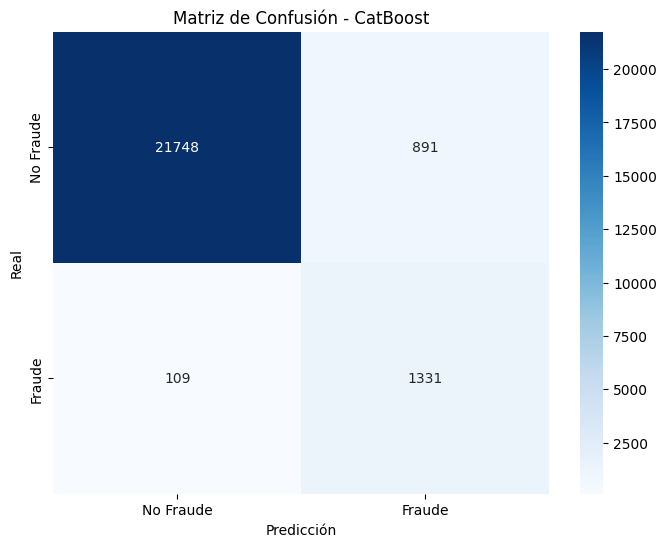



======================================== MLPClassifier ========================================
Classification Report:
              precision    recall  f1-score   support

           0     0.9907    0.9794    0.9850     22639
           1     0.7254    0.8549    0.7848      1440

    accuracy                         0.9720     24079
   macro avg     0.8580    0.9171    0.8849     24079
weighted avg     0.9748    0.9720    0.9730     24079


AUC-ROC: 0.9857
AUC-PR: 0.8915


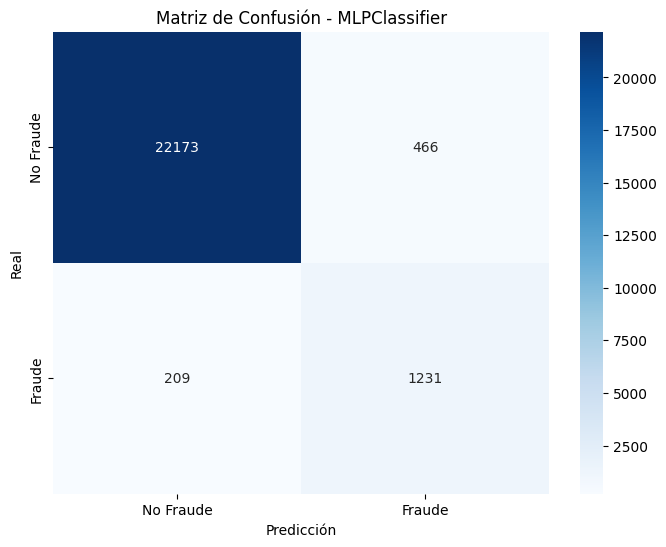



======================================== SVC ========================================
Classification Report:
              precision    recall  f1-score   support

           0     0.9925    0.9716    0.9820     22639
           1     0.6649    0.8847    0.7592      1440

    accuracy                         0.9664     24079
   macro avg     0.8287    0.9282    0.8706     24079
weighted avg     0.9729    0.9664    0.9686     24079


AUC-ROC: 0.9758
AUC-PR: 0.8681


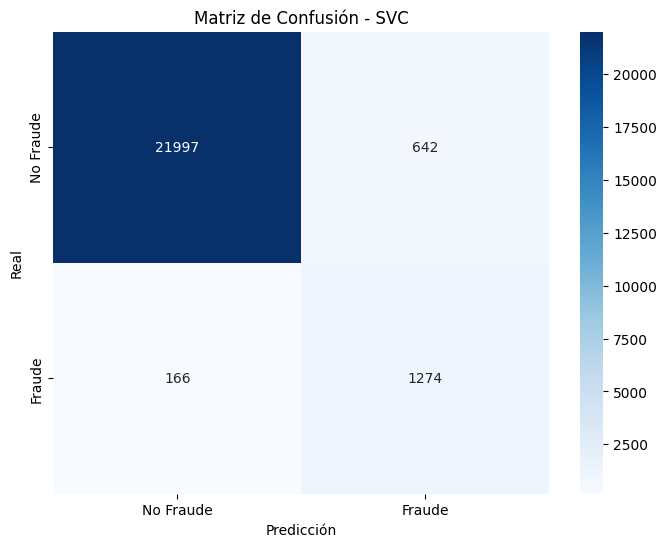

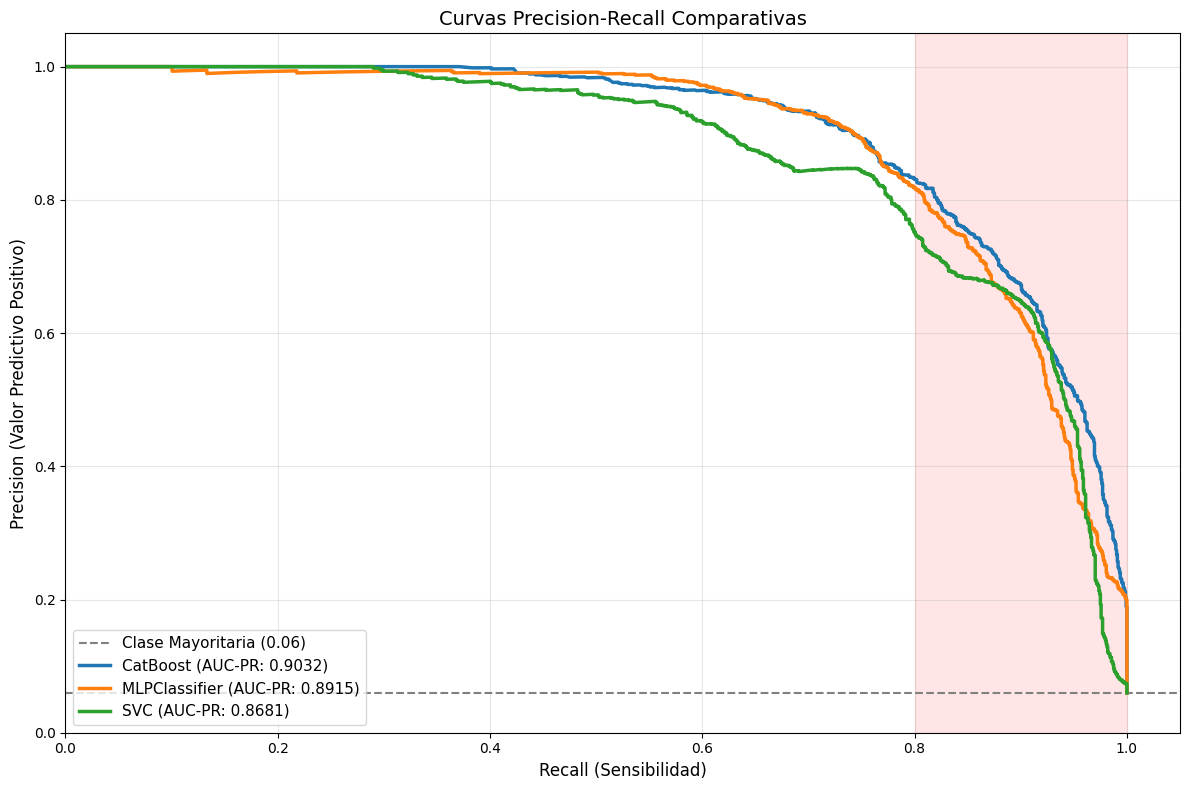

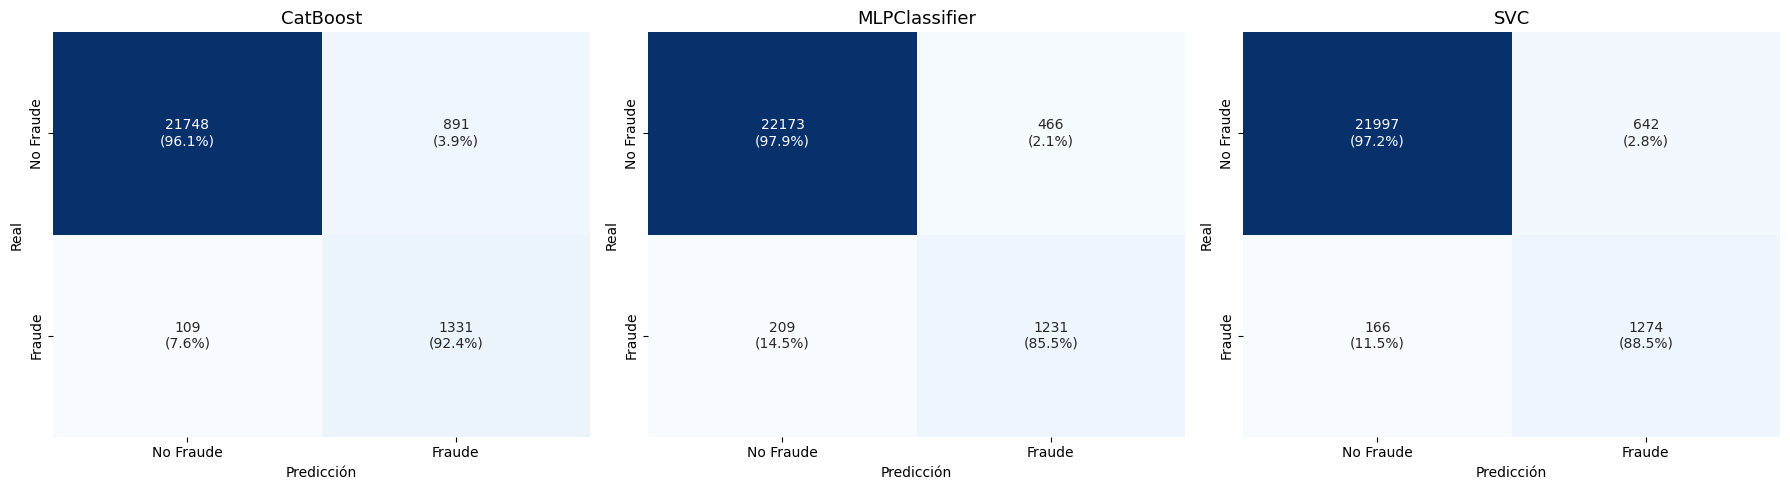


REPORTE COMPARATIVO DE MODELOS
       Modelo AUC-ROC AUC-PR Accuracy Precision (Fraude) Recall (Fraude) F1-Score (Fraude)  Support (Fraude) Diferencia Recall
     CatBoost  0.9892 0.9032   0.9585             0.5990          0.9243            0.7269            1440.0             Mejor
          SVC  0.9758 0.8681   0.9664             0.6649          0.8847            0.7592            1440.0           -0.0396
MLPClassifier  0.9857 0.8915   0.9720             0.7254          0.8549            0.7848            1440.0           -0.0694

Reporte comparativo guardado como 'comparative_model_report.csv'


,Modelo,AUC-ROC,AUC-PR,Accuracy,Precision (Fraude),Recall (Fraude),F1-Score (Fraude),Support (Fraude),Diferencia Recall
0,CatBoost,0.9892,0.9032,0.9585,0.5990,0.9243,0.7269,1440.0,Mejor
2,SVC,0.9758,0.8681,0.9664,0.6649,0.8847,0.7592,1440.0,-0.0396
1,MLPClassifier,0.9857,0.8915,0.9720,0.7254,0.8549,0.7848,1440.0,-0.0694


In [ ]:
detailed_evaluation(model_CatBoost, X_test_scaled, y_test, 'CatBoost')
detailed_evaluation(pipeline_MLP, X_test, y_test, 'MLPClassifier')
detailed_evaluation(pipeline_SVC, X_test, y_test, 'SVC')

models = ['CatBoost', 'MLPClassifier', 'SVC']

plot_combined_pr_curves(models, colors=['#1f77b4', '#ff7f0e', '#2ca02c'])

plot_combined_confusion_matrices(models)

generate_comparative_report(models)

### 5. Prueba de Modelos con Feature Engineering

In [ ]:
TARGET = 'fraud'
NUMERIC_FEATURES = ['amount']
CATEGORICAL_FEATURES_FE = ['merchant','category', 'gender', 'age','step_mod7'] #Agregamos variable creada
FEATURES_FE = NUMERIC_FEATURES + CATEGORICAL_FEATURES_FE #Agregamos variable creada

In [ ]:
X_FE = df_reducido[FEATURES_FE]
y = df_reducido[TARGET]

X_train_FE, X_test_FE, y_train, y_test = train_test_split(
    X_FE, y, 
    test_size=0.2, 
    stratify=y, #mantiene proporcion de target - importante para clases desbalanceadas
    random_state=6561
)

##### CatBoost FE

In [ ]:
scaler = RobustScaler()

# En CatBoost, aplicamos el RobustScaler manualmente y no en el Pipeline
X_train_scaled_FE = X_train_FE.copy()
X_test_scaled_FE = X_test_FE.copy()

X_train_scaled_FE[NUMERIC_FEATURES] = scaler.fit_transform(X_train_FE[NUMERIC_FEATURES])
X_test_scaled_FE[NUMERIC_FEATURES] = scaler.transform(X_test_FE[NUMERIC_FEATURES])

categorical_features_indices = [
    X_train_scaled_FE.columns.get_loc(col) 
    for col in CATEGORICAL_FEATURES_FE
]

smote_nc = SMOTENC(
    categorical_features=categorical_features_indices,
    sampling_strategy=0.3,
    random_state=6561,
    k_neighbors=5
)

X_train_res_FE, y_train_res = smote_nc.fit_resample(X_train_scaled_FE, y_train)


In [ ]:
model_CatBoost_FE = CatBoostClassifier(
    cat_features=CATEGORICAL_FEATURES_FE,
    eval_metric=metrics.AUC(), 
    custom_metric=[metrics.Recall(), metrics.Precision(), metrics.F1()],
    random_seed=6561,
    verbose=100,  # Muestra progreso cada 100 iteraciones
    early_stopping_rounds=50,
    learning_rate=0.05,
    depth=8,
    iterations=1500,
    class_weights=[1, 2]  # Mayor peso a la clase fraudulenta
)

In [ ]:
model_CatBoost_FE.fit(
    X_train_res_FE,
    y_train_res,
    eval_set=(X_test_scaled_FE, y_test),
    use_best_model=True
)

0:	test: 0.9602954	best: 0.9602954 (0)	total: 143ms	remaining: 3m 34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9889406524
bestIteration = 48

Shrink model to first 49 iterations.


#### MLPClassifier FE

Preprocesador para MLPClassifier y SVC FE

In [ ]:
preprocessor_MLP_SVC_FE = ColumnTransformer(
    transformers=[
        ('scaler', RobustScaler(), ['amount',]),
        ('onehot', OneHotEncoder(sparse_output=False), CATEGORICAL_FEATURES_FE)
    ]
)

In [ ]:
pipeline_MLP_FE = Pipeline(steps=[
    ('preprocessor', preprocessor_MLP_SVC_FE),
    ('smote', SMOTE(sampling_strategy=0.3)),  # Solo en train
    ('classifier', MLPClassifier(random_state=6561))
])

pipeline_MLP_FE.fit(X_train_FE,y_train)

c:\Users\ferna\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', RobustScaler(),
                                                  ['amount']),
                                                 ('onehot',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['merchant', 'category',
                                                   'gender', 'age',
                                                   'step_mod7'])])),
                ('smote', SMOTE(sampling_strategy=0.3)),
                ('classifier', MLPClassifier(random_state=6561))])

#### SVC FE

In [ ]:
pipeline_SVC_FE = Pipeline(steps=[
    ('preprocessor', preprocessor_MLP_SVC_FE),
    ('smote', SMOTE(sampling_strategy=0.3)),  # Solo en train
    ('classifier', SVC(random_state=6561,probability=True))
])

pipeline_SVC_FE.fit(X_train_FE,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', RobustScaler(),
                                                  ['amount']),
                                                 ('onehot',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['merchant', 'category',
                                                   'gender', 'age',
                                                   'step_mod7'])])),
                ('smote', SMOTE(sampling_strategy=0.3)),
                ('classifier', SVC(probability=True, random_state=6561))])

#### Evaluación Modelos FE



======================================== CatBoost_FE ========================================
Classification Report:
              precision    recall  f1-score   support

           0     0.9946    0.9617    0.9779     22639
           1     0.6042    0.9181    0.7288      1440

    accuracy                         0.9591     24079
   macro avg     0.7994    0.9399    0.8533     24079
weighted avg     0.9713    0.9591    0.9630     24079


AUC-ROC: 0.9889
AUC-PR: 0.8991


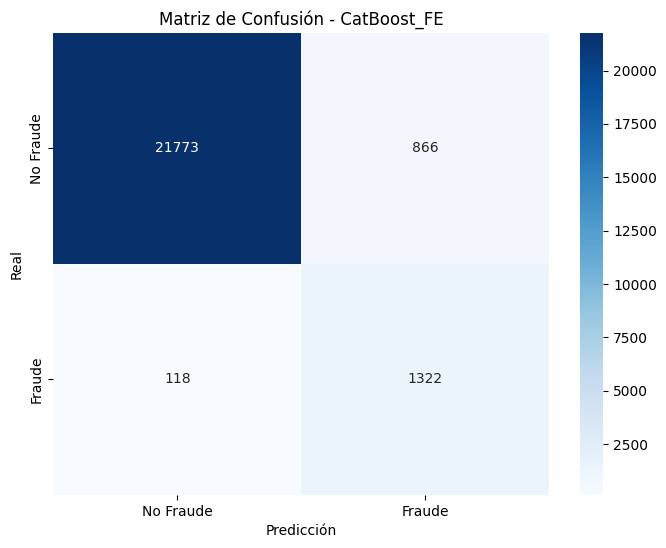



======================================== MLPClassifier_FE ========================================
Classification Report:
              precision    recall  f1-score   support

           0     0.9886    0.9804    0.9845     22639
           1     0.7279    0.8229    0.7725      1440

    accuracy                         0.9710     24079
   macro avg     0.8583    0.9017    0.8785     24079
weighted avg     0.9730    0.9710    0.9718     24079


AUC-ROC: 0.9841
AUC-PR: 0.8811


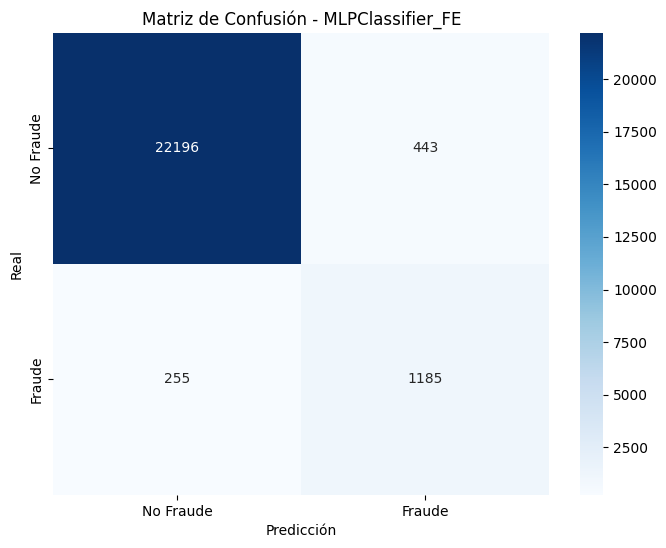



======================================== SVC_FE ========================================
Classification Report:
              precision    recall  f1-score   support

           0     0.9923    0.9727    0.9824     22639
           1     0.6729    0.8812    0.7631      1440

    accuracy                         0.9673     24079
   macro avg     0.8326    0.9270    0.8728     24079
weighted avg     0.9732    0.9673    0.9693     24079


AUC-ROC: 0.9770
AUC-PR: 0.8701


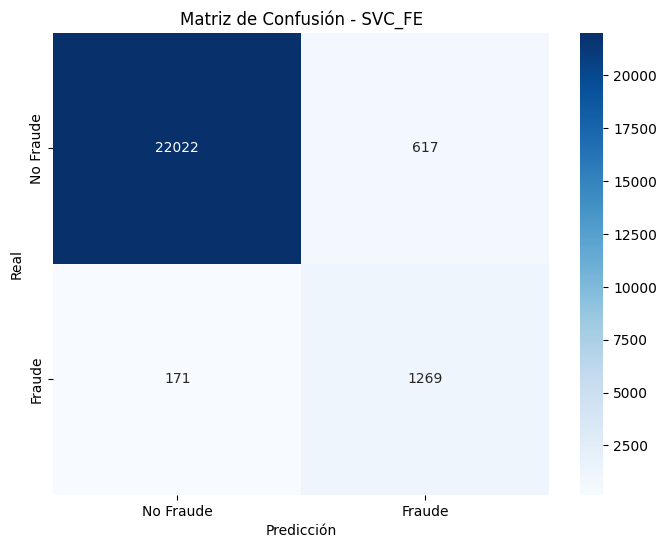

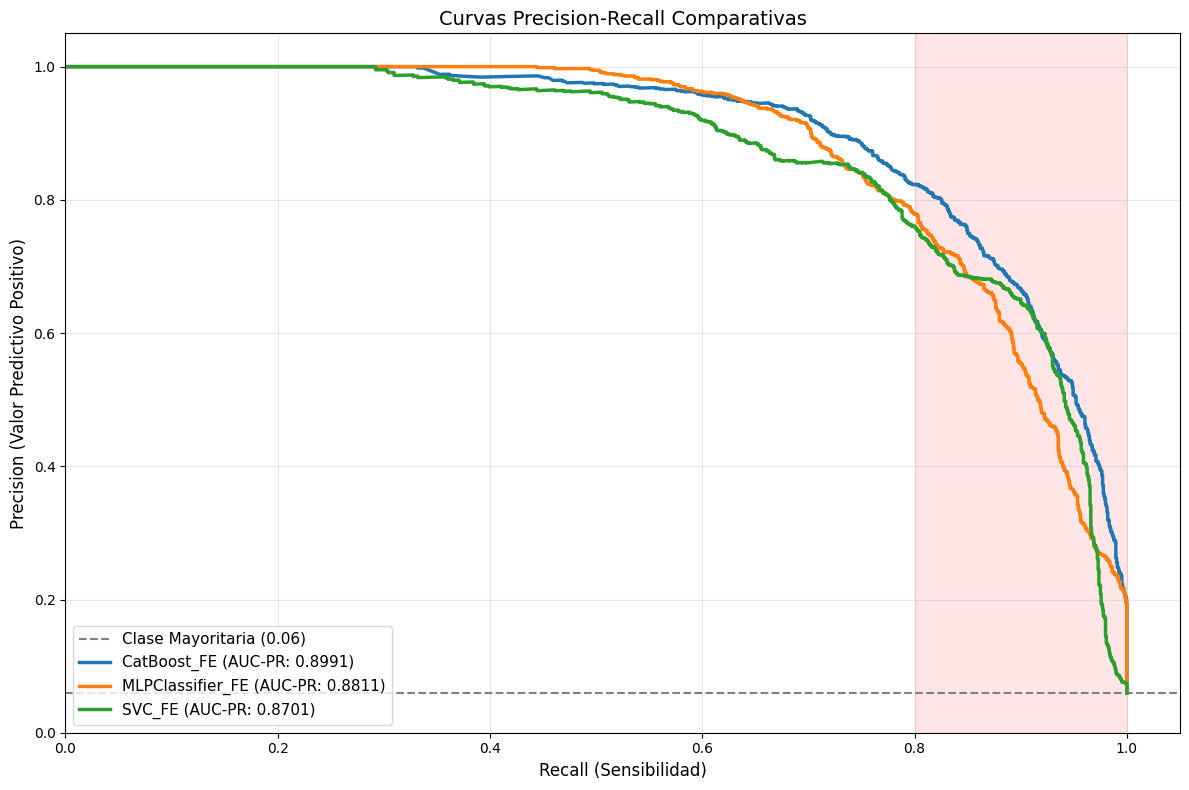

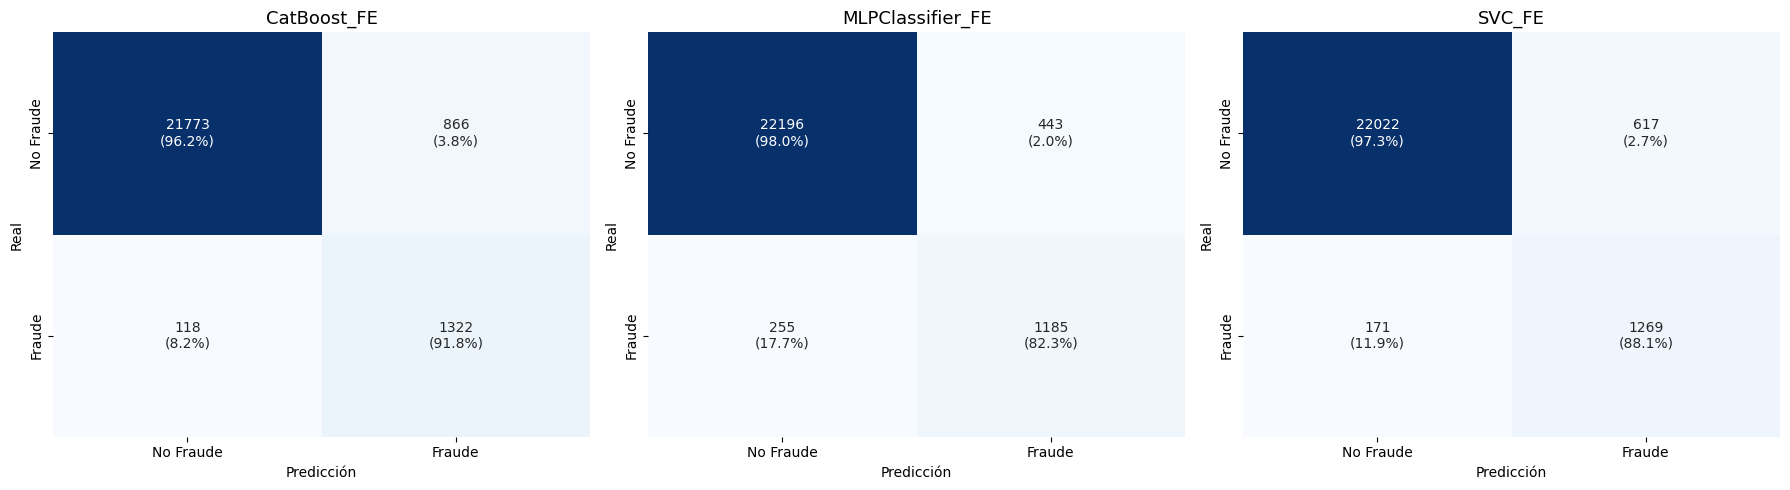


REPORTE COMPARATIVO DE MODELOS
          Modelo AUC-ROC AUC-PR Accuracy Precision (Fraude) Recall (Fraude) F1-Score (Fraude)  Support (Fraude) Diferencia Recall
     CatBoost_FE  0.9889 0.8991   0.9591             0.6042          0.9181            0.7288            1440.0             Mejor
          SVC_FE  0.9770 0.8701   0.9673             0.6729          0.8812            0.7631            1440.0           -0.0369
MLPClassifier_FE  0.9841 0.8811   0.9710             0.7279          0.8229            0.7725            1440.0           -0.0952

Reporte comparativo guardado como 'comparative_model_report.csv'


,Modelo,AUC-ROC,AUC-PR,Accuracy,Precision (Fraude),Recall (Fraude),F1-Score (Fraude),Support (Fraude),Diferencia Recall
0,CatBoost_FE,0.9889,0.8991,0.9591,0.6042,0.9181,0.7288,1440.0,Mejor
2,SVC_FE,0.9770,0.8701,0.9673,0.6729,0.8812,0.7631,1440.0,-0.0369
1,MLPClassifier_FE,0.9841,0.8811,0.9710,0.7279,0.8229,0.7725,1440.0,-0.0952


In [ ]:
detailed_evaluation(model_CatBoost_FE, X_test_scaled_FE, y_test, 'CatBoost_FE')
detailed_evaluation(pipeline_MLP_FE, X_test_FE, y_test, 'MLPClassifier_FE')
detailed_evaluation(pipeline_SVC_FE, X_test_FE, y_test, 'SVC_FE')

models2 = ['CatBoost_FE', 'MLPClassifier_FE', 'SVC_FE']

plot_combined_pr_curves(models2, colors=['#1f77b4', '#ff7f0e', '#2ca02c'])

plot_combined_confusion_matrices(models2)

generate_comparative_report(models2)

## Visualizaciones varias de Análisis Exploratorio 
- Versiones para presentación

In [29]:
df_reducido.to_csv(
    "df_reducido.csv",  # Nombre del archivo
    index=False,        # No guardar el índice (evita una columna extra)
    sep=',',            # Separador (por defecto es coma)
    encoding='utf-8'    # Codificación (evita problemas con caracteres especiales)
)

In [30]:
df_reducido.shape

(120391, 10)

- Densidad de amount - fraude vs. no fraude

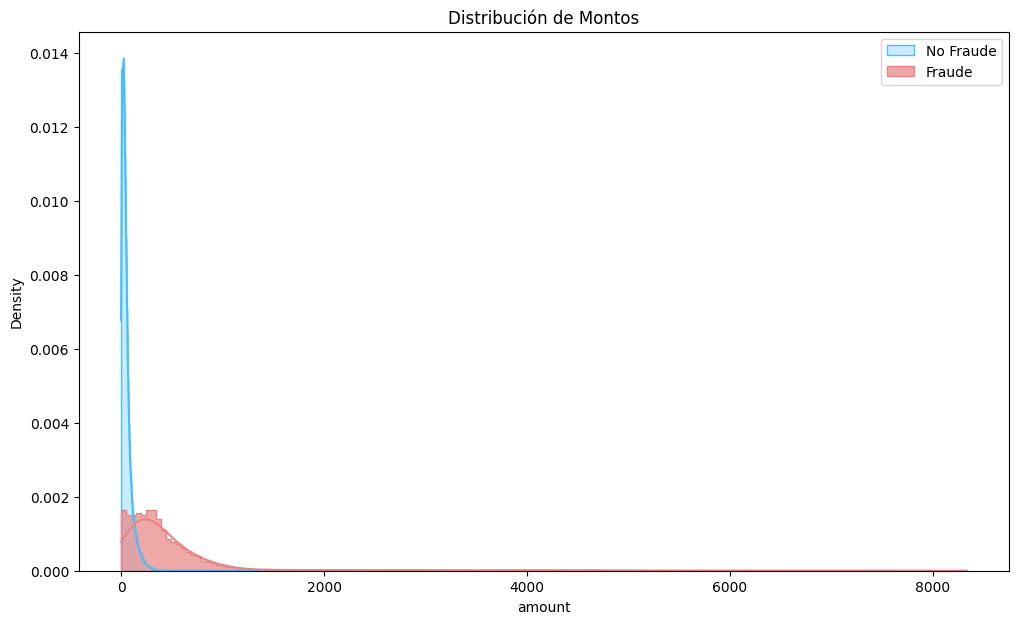

In [31]:
df_fraud = df_reducido[df_reducido['fraud'] == 1]
df_no_fraud = df_reducido[df_reducido['fraud'] == 0]


plt.figure(figsize=(12, 7))

sns.histplot((df_no_fraud['amount']), 
             kde=True, 
             element='step', 
             stat='density', 
             color="#49bff9", 
             alpha=0.3,
             label='No Fraude')

sns.histplot((df_fraud['amount']), 
             kde=True, 
             element='step', 
             stat='density', 
             color="#e88484", 
             alpha=0.7,
             label='Fraude')

plt.title('Distribución de Montos')
plt.xlabel('amount')
plt.legend()
plt.show()

- Densidad de amount (log) - fraude vs. no fraude

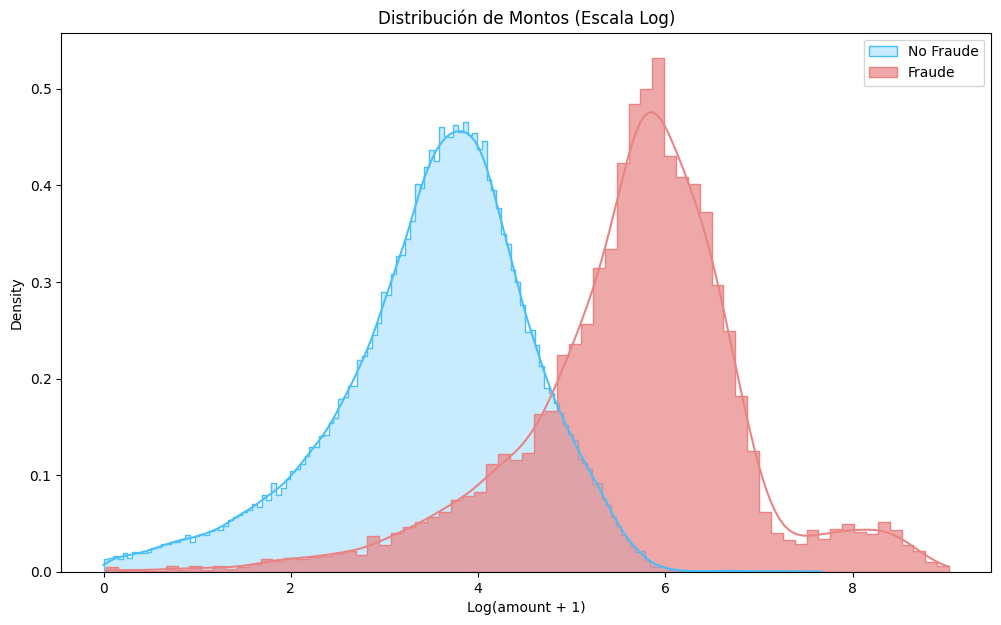

In [32]:
df_fraud = df_reducido[df_reducido['fraud'] == 1]
df_no_fraud = df_reducido[df_reducido['fraud'] == 0]


plt.figure(figsize=(12, 7))

sns.histplot(np.log1p(df_no_fraud['amount']), 
             kde=True, 
             element='step', 
             stat='density', 
             color="#49bff9", 
             alpha=0.3,
             label='No Fraude')

sns.histplot(np.log1p(df_fraud['amount']), 
             kde=True, 
             element='step', 
             stat='density', 
             color="#e88484", 
             alpha=0.7,
             label='Fraude')

plt.title('Distribución de Montos (Escala Log)')
plt.xlabel('Log(amount + 1)')
plt.legend()
plt.show()

- Conteo de transacciones por categoria - stacked bar

Pre-reducción

C:\Users\ferna\AppData\Local\Temp\ipykernel_2932\1235547669.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stack_data = df.groupby(['category', 'fraud']).size().unstack(fill_value=0)


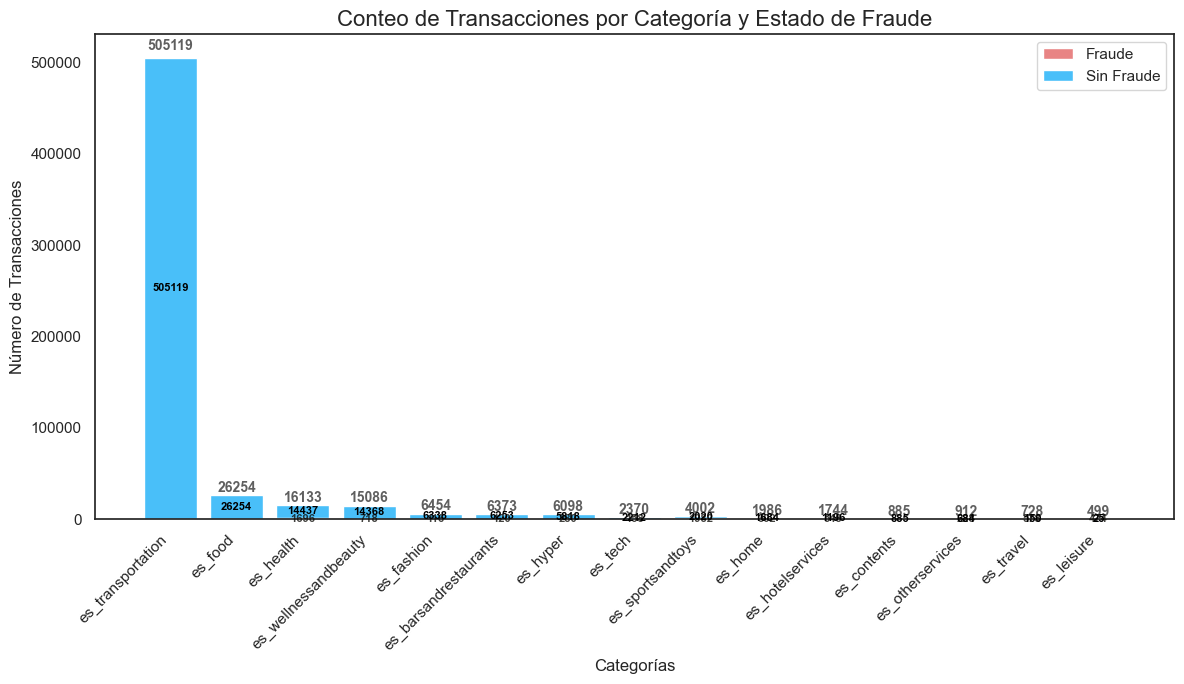

In [33]:
sns.set_theme(style="white")

stack_data = df.groupby(['category', 'fraud']).size().unstack(fill_value=0)
stack_data = stack_data.sort_values(by=[0, 1], ascending=False)


plt.figure(figsize=(12, 7))

# Graficar la parte de fraude (abajo)
fraud_bars = plt.bar(
    x=stack_data.index,
    height=stack_data[1],
    color='#e88484',
    label='Fraude'
)

# Graficar la parte sin fraude (arriba)
no_fraud_bars = plt.bar(
    x=stack_data.index,
    height=stack_data[0],
    bottom=stack_data[1],  # Apilar sobre fraude
    color='#49bff9',
    label='Sin Fraude'
)

# Personalización
plt.title('Conteo de Transacciones por Categoría y Estado de Fraude', fontsize=16)
plt.xlabel('Categorías', fontsize=12)
plt.ylabel('Número de Transacciones', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()

# Añadir etiquetas de valor para FRAUDE (blanco)
for bar in fraud_bars:
    height = bar.get_height()
    ypos = height / 2  # Centro del segmento inferior
    if height > 0:
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            ypos,
            f'{height:.0f}',
            ha='center',
            va='center',
            color="#11100cc8",
            fontweight='bold',
            fontsize=8
        )

# Añadir etiquetas de valor para SIN FRAUDE (negro)
for bar in no_fraud_bars:
    height = bar.get_height()
    bottom = bar.get_y()  # Base del segmento superior
    ypos = bottom + height / 2  # Centro del segmento superior
    if height > 0:
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            ypos,
            f'{height:.0f}',
            ha='center',
            va='center',
            color='black',
            fontweight='bold',
            fontsize=8
        )

# Añadir totales arriba de cada barra
for i, category in enumerate(stack_data.index):
    total = stack_data.loc[category].sum()
    plt.text(
        i,
        total * 1.01,
        f'{total:.0f}',
        ha='center',
        va='bottom',
        color="#000000a0",
        fontsize=10,
        fontweight='bold'
    )

plt.grid(False)

plt.tight_layout()
plt.show()

Post-reducción

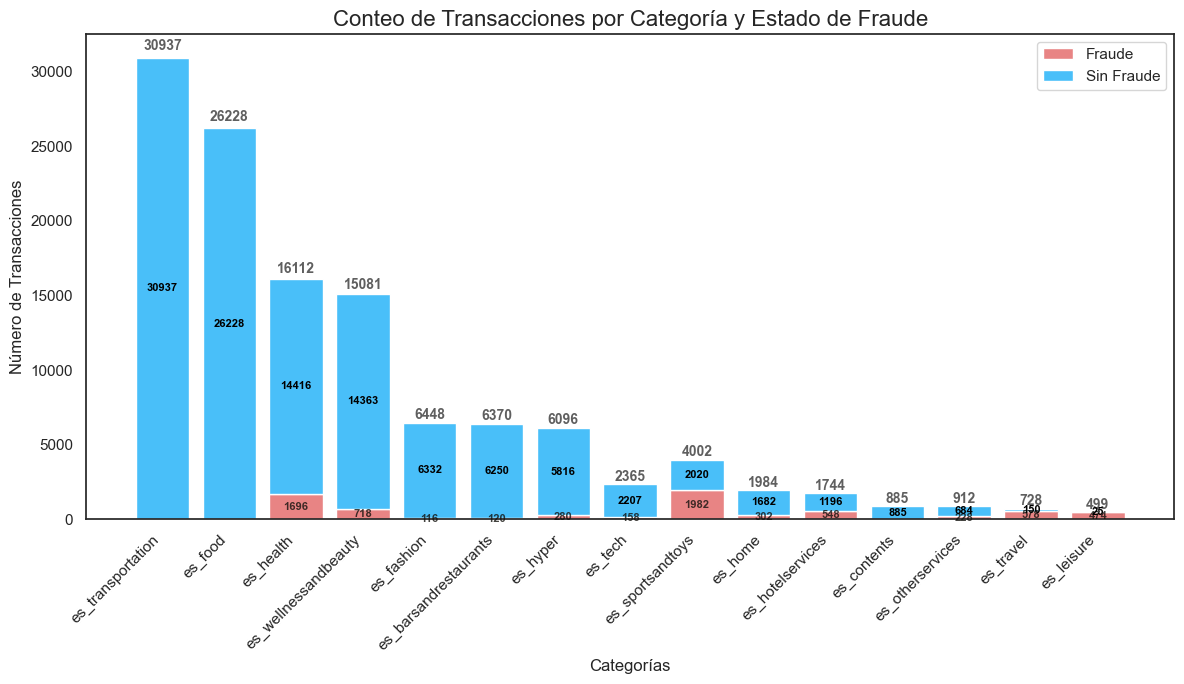

In [34]:
sns.set_theme(style="white")

stack_data = df_reducido.groupby(['category', 'fraud']).size().unstack(fill_value=0)
stack_data = stack_data.sort_values(by=[0, 1], ascending=False)


plt.figure(figsize=(12, 7))

# Graficar la parte de fraude (abajo)
fraud_bars = plt.bar(
    x=stack_data.index,
    height=stack_data[1],
    color='#e88484',
    label='Fraude'
)

# Graficar la parte sin fraude (arriba)
no_fraud_bars = plt.bar(
    x=stack_data.index,
    height=stack_data[0],
    bottom=stack_data[1],  # Apilar sobre fraude
    color='#49bff9',
    label='Sin Fraude'
)

plt.title('Conteo de Transacciones por Categoría y Estado de Fraude', fontsize=16)
plt.xlabel('Categorías', fontsize=12)
plt.ylabel('Número de Transacciones', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()

# Añadir etiquetas de valor para FRAUDE (blanco)
for bar in fraud_bars:
    height = bar.get_height()
    ypos = height / 2  # Centro del segmento inferior
    if height > 0:
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            ypos,
            f'{height:.0f}',
            ha='center',
            va='center',
            color="#11100cc8",
            fontweight='bold',
            fontsize=8
        )

# Añadir etiquetas de valor para SIN FRAUDE (negro)
for bar in no_fraud_bars:
    height = bar.get_height()
    bottom = bar.get_y()  # Base del segmento superior
    ypos = bottom + height / 2  # Centro del segmento superior
    if height > 0:
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            ypos,
            f'{height:.0f}',
            ha='center',
            va='center',
            color='black',
            fontweight='bold',
            fontsize=8
        )

# Añadir totales arriba de cada barra
for i, category in enumerate(stack_data.index):
    total = stack_data.loc[category].sum()
    plt.text(
        i,
        total * 1.01,
        f'{total:.0f}',
        ha='center',
        va='bottom',
        color="#000000a0",
        fontsize=10,
        fontweight='bold'
    )

plt.grid(False)

plt.tight_layout()
plt.show()

- 100% stacked column chart

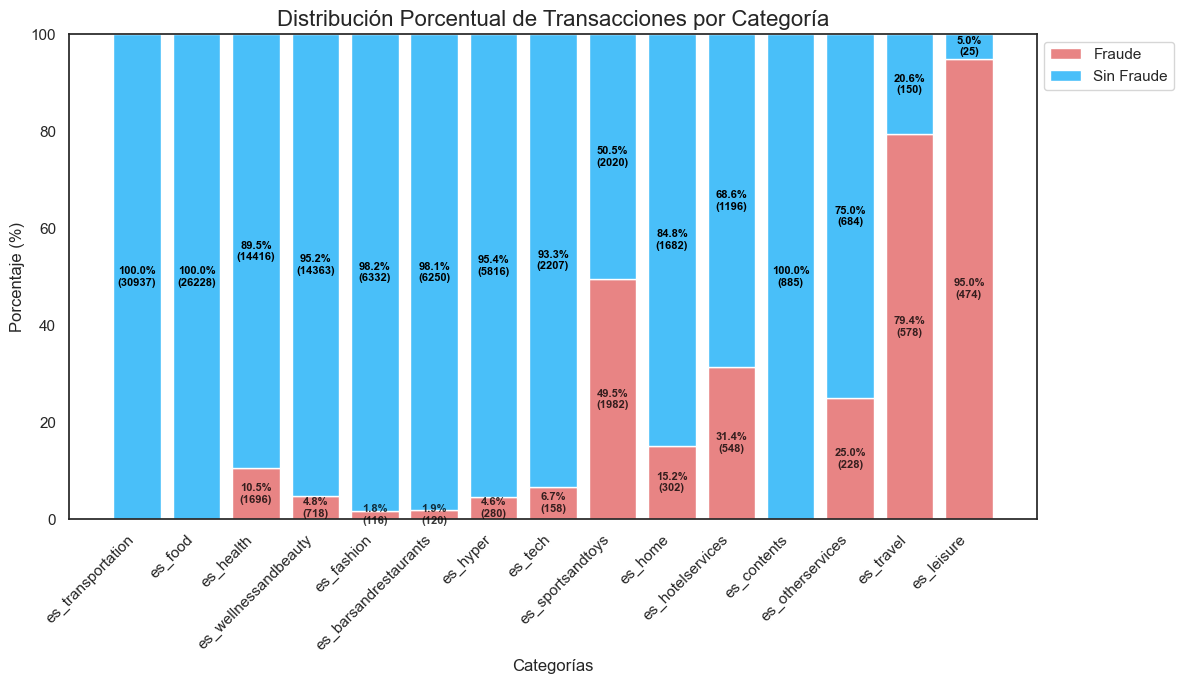

In [35]:
sns.set_theme(style="white")

# Calcular conteos
stack_data = df_reducido.groupby(['category', 'fraud']).size().unstack(fill_value=0)
stack_data = stack_data.sort_values(by=[0, 1], ascending=False)

# Calcular porcentajes
total_por_categoria = stack_data.sum(axis=1)
fraud_perc = (stack_data[1] / total_por_categoria * 100).round(1)
no_fraud_perc = (stack_data[0] / total_por_categoria * 100).round(1)

plt.figure(figsize=(12, 7))

# Graficar la parte de fraude (abajo)
fraud_bars = plt.bar(
    x=stack_data.index,
    height=fraud_perc,  # Porcentaje de fraude
    color='#e88484',
    label='Fraude'
)

# Graficar la parte sin fraude (arriba)
no_fraud_bars = plt.bar(
    x=stack_data.index,
    height=no_fraud_perc,  # Porcentaje sin fraude
    bottom=fraud_perc,  # Apilar sobre fraude
    color='#49bff9',
    label='Sin Fraude'
)

# Personalización
plt.title('Distribución Porcentual de Transacciones por Categoría', fontsize=16)
plt.xlabel('Categorías', fontsize=12)
plt.ylabel('Porcentaje (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim(0, 100)  # Eje Y de 0% a 100%

# Añadir etiquetas de porcentaje para FRAUDE
for i, bar in enumerate(fraud_bars):
    height = bar.get_height()
    if height > 0:
        # Mostrar porcentaje y conteo
        count = stack_data.iloc[i, 1]
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height/2,
            f'{height}%\n({count})',
            ha='center',
            va='center',
            color="#000000c5",
            fontweight='bold',
            fontsize=8
        )

# Añadir etiquetas de porcentaje para SIN FRAUDE
for i, bar in enumerate(no_fraud_bars):
    height = bar.get_height()
    bottom = bar.get_y()
    if height > 0:
        # Mostrar porcentaje y conteo
        count = stack_data.iloc[i, 0]
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            bottom + height/2,
            f'{height}%\n({count})',
            ha='center',
            va='center',
            color='black',
            fontweight='bold',
            fontsize=8
        )


plt.grid(False)
plt.tight_layout()
plt.show()

- Distribución de conteo de fraudes por merchant

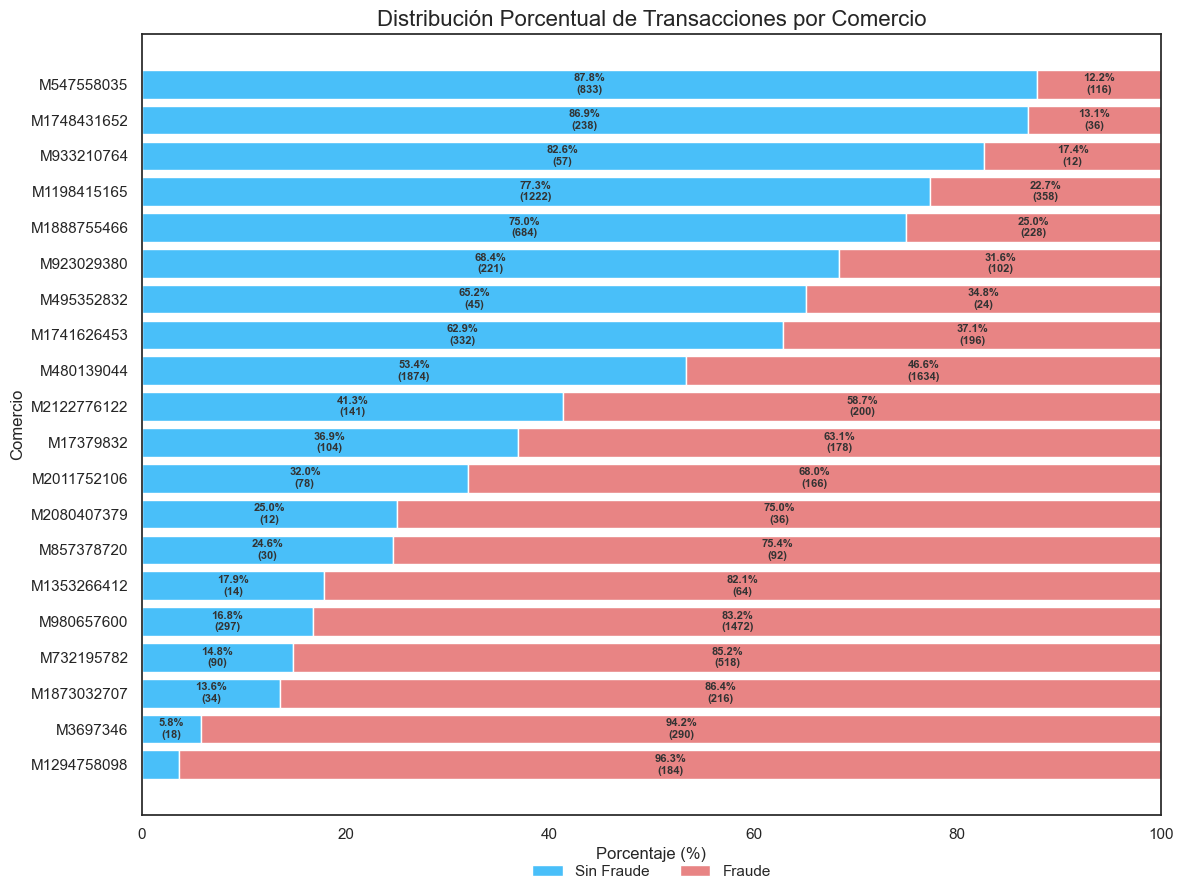

In [40]:
sns.set_theme(style="white")

# Agrupar por merchant y fraud
merchant_data = df_reducido.groupby(['merchant', 'fraud']).size().unstack(fill_value=0)

# Calcular porcentajes y ordenar por fraude descendente
total_por_merchant = merchant_data.sum(axis=1)
fraud_perc_merchant = (merchant_data[1] / total_por_merchant * 100).round(1)
no_fraud_perc_merchant = (merchant_data[0] / total_por_merchant * 100).round(1)

# Ordenar por porcentaje de fraude descendente
sorted_index = fraud_perc_merchant.sort_values(ascending=False).index
merchant_data = merchant_data.loc[sorted_index]
fraud_perc_merchant = fraud_perc_merchant.loc[sorted_index]
no_fraud_perc_merchant = no_fraud_perc_merchant.loc[sorted_index]

# Seleccionar los top merchants (ajustar según necesidad)
top_merchants = 20  # Mostrar top 20 merchants
if len(merchant_data) > top_merchants:
    merchant_data = merchant_data.head(top_merchants)
    fraud_perc_merchant = fraud_perc_merchant.head(top_merchants)
    no_fraud_perc_merchant = no_fraud_perc_merchant.head(top_merchants)

plt.figure(figsize=(12, 10))

# Graficar la parte sin fraude (izquierda)
no_fraud_bars = plt.barh(
    y=merchant_data.index,
    width=no_fraud_perc_merchant,
    color='#49bff9',
    label='Sin Fraude'
)

# Graficar la parte de fraude (derecha)
fraud_bars = plt.barh(
    y=merchant_data.index,
    width=fraud_perc_merchant,
    left=no_fraud_perc_merchant,
    color='#e88484',
    label='Fraude'
)

plt.title('Distribución Porcentual de Transacciones por Comercio', fontsize=16)
plt.xlabel('Porcentaje (%)', fontsize=12)
plt.ylabel('Comercio', fontsize=12)
plt.xlim(0, 100)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2, frameon=False)

# Configurar estilo de texto
text_style = {
    'color': '#333333',  # Gris oscuro
    'fontweight': 'bold',
    'fontsize': 8
}

# Añadir etiquetas de porcentaje
for i, merchant in enumerate(merchant_data.index):
    # Obtener valores
    fraud_value = fraud_perc_merchant.iloc[i]
    no_fraud_value = no_fraud_perc_merchant.iloc[i]
    fraud_count = merchant_data.loc[merchant, 1]
    no_fraud_count = merchant_data.loc[merchant, 0]
    
    # Etiqueta para segmento SIN FRAUDE
    if no_fraud_value > 5:  # Solo mostrar si el segmento es suficientemente ancho
        plt.text(
            no_fraud_value/2, 
            i, 
            f'{no_fraud_value:.1f}%\n({no_fraud_count})', 
            va='center', 
            ha='center',
            **text_style
        )
    
    # Etiqueta para segmento FRAUDE
    if fraud_value > 5:  # Segmento ancho - texto dentro
        plt.text(
            no_fraud_value + fraud_value/2, 
            i, 
            f'{fraud_value:.1f}%\n({fraud_count})', 
            va='center', 
            ha='center',
            **text_style
        )
    elif fraud_value > 0:  # Segmento estrecho - texto fuera
        plt.text(
            no_fraud_value + fraud_value + 1, 
            i, 
            f'{fraud_value:.1f}%\n({fraud_count})', 
            va='center', 
            ha='left',
            **text_style
        )

# Ajustar márgenes para asegurar que todo esté dentro del marco
plt.tight_layout(rect=[0, 0.05, 1, 0.96])  # Ajustar espacio inferior

plt.grid(False)
plt.show()

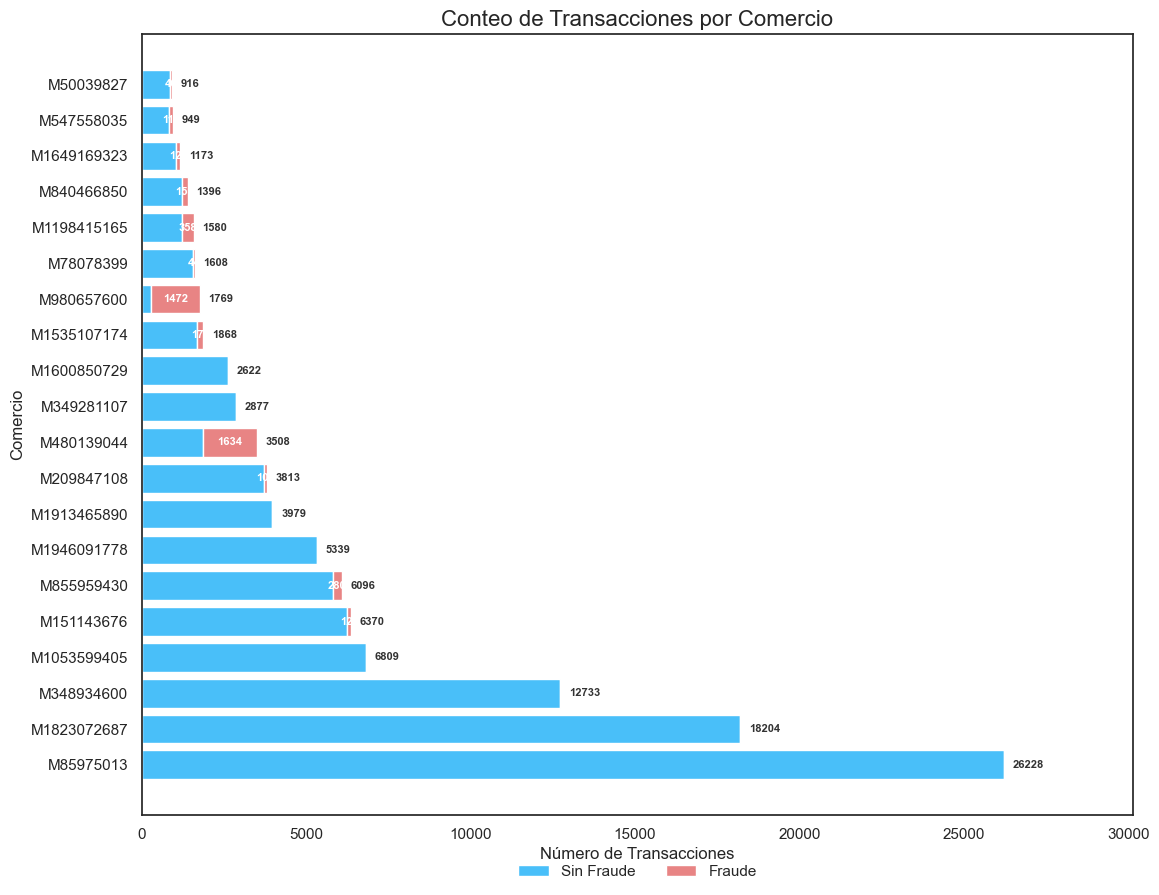

In [42]:
sns.set_theme(style="white")

# Agrupar por merchant y fraud
merchant_data = df_reducido.groupby(['merchant', 'fraud']).size().unstack(fill_value=0)

# Ordenar por cantidad total de transacciones (opcional: usar sort_values(1) para ordenar por fraudes)
merchant_data['total'] = merchant_data.sum(axis=1)
merchant_data = merchant_data.sort_values('total', ascending=False)

# Seleccionar los top merchants
top_merchants = 20
merchant_data = merchant_data.head(top_merchants)

# Separar los datos
no_fraud_counts = merchant_data[0]
fraud_counts = merchant_data[1]
merchants = merchant_data.index

plt.figure(figsize=(12, 10))

# Crear posición en el eje Y
y_pos = np.arange(len(merchants))

# Graficar barras para transacciones sin fraude
plt.barh(
    y_pos, 
    no_fraud_counts,
    color='#49bff9',  # Azul claro
    label='Sin Fraude'
)

# Graficar barras para transacciones con fraude (encima de las anteriores)
plt.barh(
    y_pos, 
    fraud_counts,
    left=no_fraud_counts,  # Apilar sobre las barras azules
    color='#e88484',  # Rojo claro
    label='Fraude'
)

plt.title('Conteo de Transacciones por Comercio', fontsize=16)
plt.xlabel('Número de Transacciones', fontsize=12)
plt.ylabel('Comercio', fontsize=12)
plt.yticks(y_pos, merchants)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2, frameon=False)

# Añadir etiquetas de valor
for i, (total, fraud) in enumerate(zip(merchant_data['total'], merchant_data[1])):
    # Etiqueta para el total
    plt.text(
        total + max(merchant_data['total']) * 0.01,  # Pequeño espacio a la derecha
        i,
        f'{total}',
        va='center',
        ha='left',
        color='#333333',
        fontweight='bold',
        fontsize=8
    )
    
    # Etiqueta para fraudes (solo si hay casos)
    if fraud > 0:
        plt.text(
            no_fraud_counts.iloc[i] + fraud/2, 
            i,
            f'{fraud}',
            va='center',
            ha='center',
            color='white',
            fontweight='bold',
            fontsize=8
        )

# Ajustar márgenes
plt.tight_layout(rect=[0, 0.05, 1, 0.96])
plt.xlim(0, max(merchant_data['total']) * 1.15)  # Dejar espacio para etiquetas
plt.grid(False)
plt.show()